# FreeAgent 

### Questions

1. Examine the provided data. Are there any differences in properties of behaviour between those customers that subscribe and those that do not?

2. Construct a model to predict if a customer will subscribe after their free trial and demonstrate its performance.

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

from sklearn.svm import SVC

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedKFold 
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve

from scipy.stats import randint, uniform


seed = 9090
np.random.seed(seed)

### Data preprocessing

#### Preprocesses attributes report

In [98]:
raw_data_attributes = pd.read_csv('attributes_report.csv')
raw_data_attributes.head(5)

,company,company_type,subscribed_after_free_trial
0,346782,uk_limited_company,False
1,346783,uk_limited_company,False
2,346784,uk_limited_company,True
3,346785,uk_limited_company,False
4,346786,uk_limited_company,False


In [99]:
data_attributes = pd.DataFrame(raw_data_attributes)
print("All possible company types: ", data_attributes.company_type.unique())

All possible company types:  ['uk_limited_company' 'uk_sole_trader' 'universal_company']


#### Preprocess engagement report log

In [100]:
with open('engagement_report.log') as f:
    raw_data_logs = f.readlines()

In [101]:
data_logs = pd.DataFrame(columns=['company', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7']) # create data frame of the log

In [102]:
record_index = 0    
for day in range(len(raw_data_logs)):
    if (day % 7 == 0):
        row = []
        company = int(raw_data_logs[day][8:14])
        day1 = int(raw_data_logs[day][25:26])
        day2 = int(raw_data_logs[day + 1][25:26])
        day3 = int(raw_data_logs[day + 2][25:26])
        day4 = int(raw_data_logs[day + 3][25:26])
        day5 = int(raw_data_logs[day + 4][25:26])
        day6 = int(raw_data_logs[day + 5][25:26])
        day7 = int(raw_data_logs[day + 6][25:26])        
        
        row = [company, day1, day2, day3, day4, day5, day6, day7]
        data_logs.loc[record_index] = row
        record_index += 1

data_logs.head()

,company,day1,day2,day3,day4,day5,day6,day7
0,346782,1,0,1,0,1,0,0
1,346783,0,0,0,0,0,0,0
2,346784,1,0,0,1,4,1,0
3,346785,0,0,0,0,0,0,0
4,346786,0,0,0,0,0,0,0


In [103]:
# join the attributes report with the log on the company unique number
data = pd.merge(data_attributes, data_logs, on='company', how='inner')
data.head()

,company,company_type,subscribed_after_free_trial,day1,day2,day3,day4,day5,day6,day7
0,346782,uk_limited_company,False,1,0,1,0,1,0,0
1,346783,uk_limited_company,False,0,0,0,0,0,0,0
2,346784,uk_limited_company,True,1,0,0,1,4,1,0
3,346785,uk_limited_company,False,0,0,0,0,0,0,0
4,346786,uk_limited_company,False,0,0,0,0,0,0,0


In [80]:
data_no_sub = data.loc[data['subscribed_after_free_trial'] == False]

num_rows = len(data_no_sub)
print("Number of no subs: " + str(num_rows))

data_no_sub_avg_day1 = data_no_sub['day1'].sum() / num_rows
data_no_sub_avg_day2 = data_no_sub['day2'].sum() / num_rows
data_no_sub_avg_day3 = data_no_sub['day3'].sum() / num_rows
data_no_sub_avg_day4 = data_no_sub['day4'].sum() / num_rows
data_no_sub_avg_day5 = data_no_sub['day5'].sum() / num_rows
data_no_sub_avg_day6 = data_no_sub['day6'].sum() / num_rows
data_no_sub_avg_day7 = data_no_sub['day7'].sum() / num_rows


data_no_sub_all_days = [data_no_sub_avg_day1, data_no_sub_avg_day2, data_no_sub_avg_day3, data_no_sub_avg_day4, data_no_sub_avg_day5, data_no_sub_avg_day6, data_no_sub_avg_day7]


Number of no subs: 789


In [81]:
data_yes_sub = data.loc[data['subscribed_after_free_trial'] == True]

num_rows = len(data_yes_sub)
print("Number of subs: " + str(num_rows))

data_yes_sub_avg_day1 = data_yes_sub['day1'].sum() / num_rows
data_yes_sub_avg_day2 = data_yes_sub['day2'].sum() / num_rows
data_yes_sub_avg_day3 = data_yes_sub['day3'].sum() / num_rows
data_yes_sub_avg_day4 = data_yes_sub['day4'].sum() / num_rows
data_yes_sub_avg_day5 = data_yes_sub['day5'].sum() / num_rows
data_yes_sub_avg_day6 = data_yes_sub['day6'].sum() / num_rows
data_yes_sub_avg_day7 = data_yes_sub['day7'].sum() / num_rows

data_yes_sub_all_days = [data_yes_sub_avg_day1, data_yes_sub_avg_day2, data_yes_sub_avg_day3, data_yes_sub_avg_day4, data_yes_sub_avg_day5, data_yes_sub_avg_day6, data_yes_sub_avg_day7]


Number of subs: 161


#### Plot average number of website visits per day for no subscription and subscription

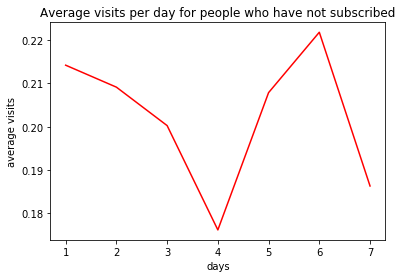

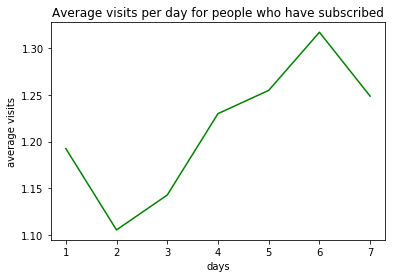

In [113]:
plt.plot([1, 2, 3, 4, 5, 6, 7], data_no_sub_all_days, color='r')
plt.xlabel('days')
plt.ylabel('average visits')
plt.title('Average visits per day for people who have not subscribed')
plt.show()

plt.plot([1, 2, 3, 4, 5, 6, 7], data_yes_sub_all_days, color='g')
plt.xlabel('days')
plt.ylabel('average visits')
plt.title('Average visits per day for people who have subscribed')
plt.show()

#### Prepare data for training

In [84]:
X = data.drop('company', axis=1)
X = pd.get_dummies(X, columns=['company_type']) # convert categorical variables to dummy variables
Y = X['subscribed_after_free_trial'] # get the labels e.g subscribed_after_free_trial
X = X.drop('subscribed_after_free_trial', axis=1) # remove labels column from the training data
X = X.astype(dtype={"day1":"int32", "day2":"int32", "day3":"int32", "day4":"int32", "day5":"int32", "day6":"int32", "day7":"int32"})

### XGBoost model

In [85]:
cv = StratifiedKFold(Y, n_folds=10, shuffle=True, random_state=seed) # Define cross-validation strategy for testing.

In [116]:
# perform randomized grid search with xgboost

params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

params_dist_grid = {
    'max_depth': [1, 2, 3, 4],
    'gamma': [0, 0.5, 1],
    'n_estimators': randint(1, 1001), # uniform discrete random distribution
    'learning_rate': uniform(), # gaussian distribution
    'subsample': uniform(),
    'colsample_bytree': uniform() 
}

grid_search_xgboost= RandomizedSearchCV (
    estimator = XGBClassifier(**params_fixed, seed=seed),
    param_distributions = params_dist_grid,
    n_iter = 10,
    cv = cv,
    scoring= 'f1_weighted',
    random_state = seed
)

In [117]:
grid_search_xgboost.fit(X, Y)

RandomizedSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[False False ..., False False], n_folds=10, shuffle=True, random_state=9090),
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=9090, silent=1, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': [1, 2, 3, 4], 'gamma': [0, 0.5, 1], 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a19e949b0>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a19e98e80>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a19e983c8>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0

In [123]:
grid_search_xgboost.best_params_

{'colsample_bytree': 0.2083714879080083,
 'gamma': 0.5,
 'learning_rate': 0.10958394187471121,
 'max_depth': 4,
 'n_estimators': 172,
 'subsample': 0.702805891938864}

In [125]:
print("F1 score: " + str(grid_search_xgboost.best_score_))

F1 score: 0.9731955594041168


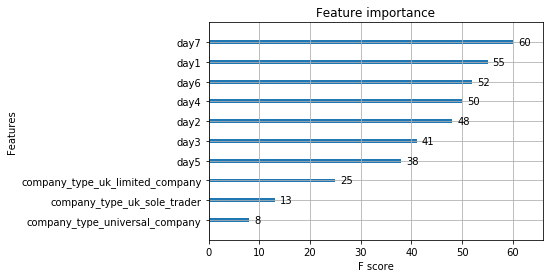

In [122]:
plot_importance(grid_search_xgboost.best_estimator_)
plt.show()

### SVM model with rbf kernel

In [126]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = { 'gamma': gamma_range, 
                'C': C_range
             }
cv = StratifiedKFold(Y, n_folds=10, shuffle=True, random_state=seed)
grid_search_svm = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid_search_svm.fit(X, Y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[False False ..., False False], n_folds=10, shuffle=True, random_state=9090),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, ver

In [130]:
print("Accuracy : " + str(grid_search_svm.best_score_))

Accuracy : 0.9778947368421053
